# Titanic Prediction using Python
### A huge thank you to Jose Portilla and his Udemy course for teaching me https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp/learn/v4

## Imports and reading in files

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

import warnings
#warnings.filterwarnings('ignore')


In [67]:
df = pd.read_csv("../input/train.csv")

In [99]:
#Check that the file was read in properly and explore the columns
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data exploration

In [107]:
counter = df.isnull().sum()
counter.map(lambda x : x/df.count().max()*100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

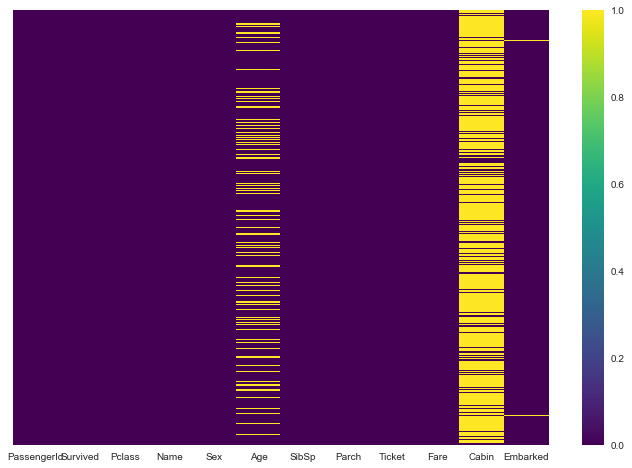

In [73]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(),cbar=True, yticklabels=False, cmap='viridis')

From the heat map, we can see that a lot of the 'Cabin' row information is missing. However, while the age column is also missing some data, we can use imputation to fill in some of the data later. Additionally, the 'Embarked' column has so few rows missing, that we can just delete those.

In [36]:
sns.set_style('darkgrid')

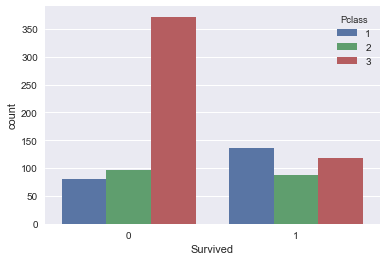

In [37]:
sns.countplot(x='Survived', data=df, hue='Pclass')

We can see here that those who did not survive were predominantly from the 3rd Passenger Class (Pclass).

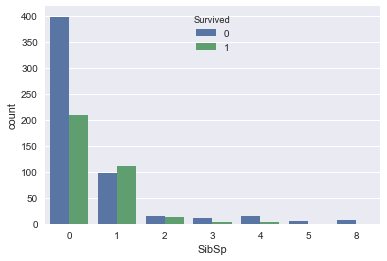

In [38]:
sns.countplot(x='SibSp', data=df, hue='Survived')

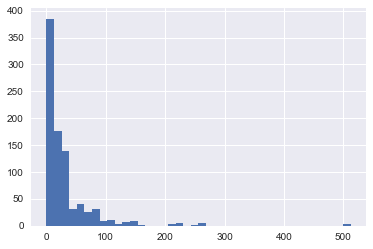

In [115]:
df['Fare'].hist(bins=40)

Here, we impute the age of those we do not have information on. We use a boxplot to estimate the median age of each class, and impute that into the age for the rows with missing age.

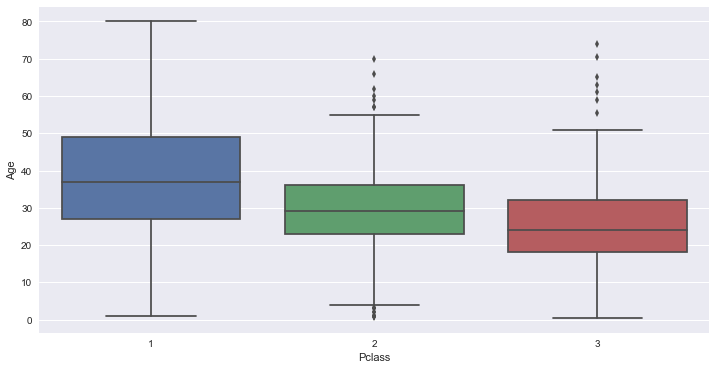

In [40]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Pclass', y='Age', data=df)

In [41]:
def inpute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else: return 24
    else: return Age

In [42]:
df['Age']=df[['Age','Pclass']].apply(inpute_age, axis=1)

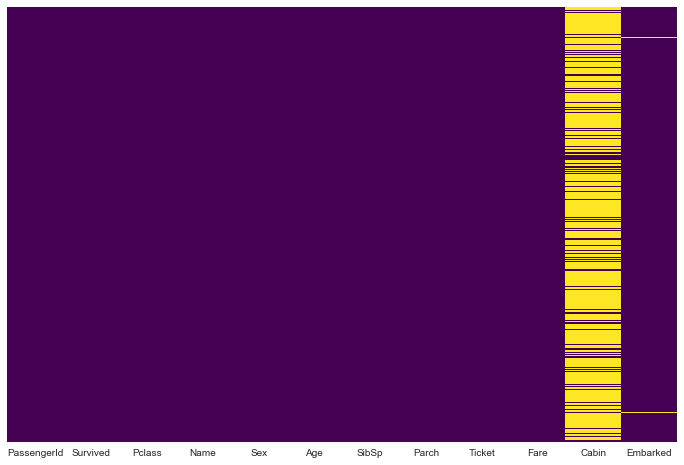

In [43]:
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(),cbar=False, yticklabels=False, cmap='viridis')

You can see now the data is cleaner, but we still need to clean the 'Cabin' and 'Embarked' columns. For now, we will simply drop the 'Cabin' column and drop the rows where 'Embarked' is missing.

In [44]:
df.drop('Cabin', axis=1, inplace=True)

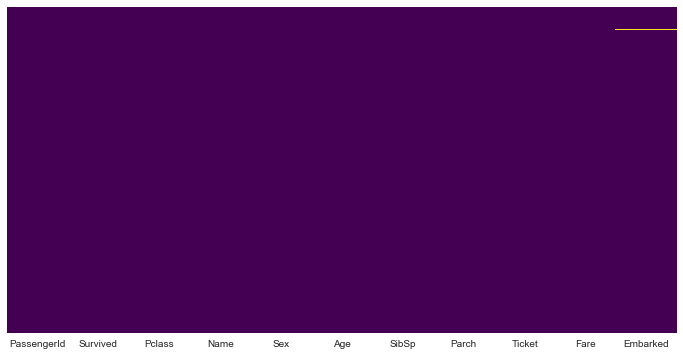

In [45]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(),cbar=False, yticklabels=False, cmap='viridis')

In [46]:
df.dropna(inplace=True)

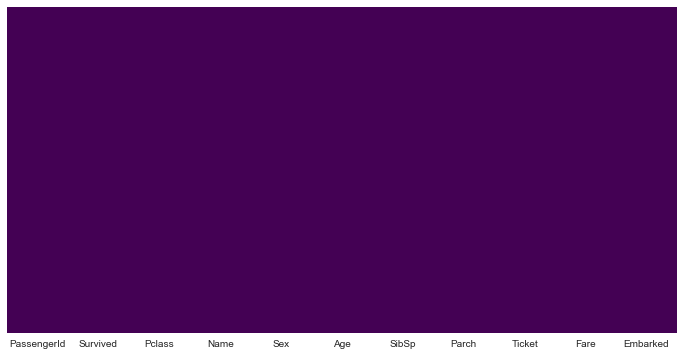

In [47]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(),cbar=False, yticklabels=False, cmap='viridis')

The data is now clean of null values, but we still need to take care of objects that a machine learning algorithm can't handle, namely strings.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Name           889 non-null object
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Ticket         889 non-null object
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


We can see that 'Name', 'Sex', 'Ticket', and 'Embarked' are all objects. In this case, they indeed are all strings. We will use Pandas built in getDummies() funciton to convert those to numbers.

In [49]:
#We make a new 'Male columns because getDummies will drop one the the dummy variables
#to ensure linear independence.
df['Male'] = pd.get_dummies(df['Sex'], drop_first=True)

In [50]:
#The embarked column indicates where the passenger boarded the Titanic.
#It has three values ['S','C','Q']
embarked = pd.get_dummies(df['Embarked'], drop_first=True)
df = pd.concat([df, embarked], axis=1)

In [51]:
#These columns do not provide us any information for the following reasons:
#PassengerID: we consider 'PassengerID' a randomly assigned ID thus not correlated with surviability
#Name: we are not performing any feature extraction from the name, so we must drop tihs non-numerical column
#Sex: the 'Male' column already captures all information about the sex of the passenger
#Ticket: we are not performing any feature extraction, so we must drop this non-numerical column
#Embarked: we have extracted the dummy values, so those two numerical dummy values encapsulate all the embarked info

df.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked'], axis=1, inplace=True)

In [52]:
#Take a look at our new dataframe
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Fare        889 non-null float64
Male        889 non-null uint8
Q           889 non-null uint8
S           889 non-null uint8
dtypes: float64(2), int64(4), uint8(3)
memory usage: 51.2 KB


##Build and train the model

In [54]:
#Seperate the feature columns from the target column
X = df.drop('Survived', axis=1)
y = df['Survived']

In [55]:
#Split the data into two. I don't think this is necessary since there are two files.
#I will keep this here for now
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [56]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's get our model accuracy based on our test data

In [129]:
predicted = logmodel.predict(X_test)
print('accuracy is: {:.0%}'.format((predicted == y_test).sum()/y_test.count()))

accuracy is: 79%


In [57]:
#Read in the test data
test_df = pd.read_csv('../input/test.csv')

In [58]:
#Clean the test data the same way we did the training data
test_df['Age']=test_df[['Age','Pclass']].apply(inpute_age, axis=1)
test_df.drop('Cabin', axis=1, inplace=True)
test_df.dropna(inplace=True)
test_df['Male'] = pd.get_dummies(test_df['Sex'], drop_first=True)
embarked = pd.get_dummies(test_df['Embarked'], drop_first=True)
test_df = pd.concat([test_df, embarked], axis=1)
pass_ids = test_df['PassengerId']
test_df.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Embarked'], axis=1, inplace=True)

In [59]:
test_df.tail()

,Pclass,Age,SibSp,Parch,Fare,Male,Q,S
413,3,24.0,0,0,8.0500,1,0,1
414,1,39.0,0,0,108.9000,0,0,0
415,3,38.5,0,0,7.2500,1,0,1
416,3,24.0,0,0,8.0500,1,0,1
417,3,24.0,1,1,22.3583,1,0,0


In [116]:
predictions = logmodel.predict(test_df)

In [61]:
submission = pd.DataFrame({
        "PassengerId": pass_ids,
        "Survived": predictions
    })
submission.to_csv('titanic.csv', index=False)